In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random 

from scipy.optimize import brentq
from scipy import interpolate

import joblib
from IPython import embed
from sklearn.metrics import roc_curve, auc
import seaborn as sns

import pandas as pd

import os
import os, errno, re
import os.path as path

import tqdm 
import glob 

from IPython import embed
from pathlib import Path 

df_1layer = joblib.load('../../experiments/6folds_1layer_kaldi_labels/eval/data_for_eval.picke')
df_1layer = df_1layer.rename(columns={"phone_automatic": "phones_names", "gop_scores": "gop_score"})

#df_2layers = joblib.load('../../experiments/6folds_2layers_kaldi_labels/eval/data_for_eval.pickle')
#df_2layers = df_2layers.rename(columns={"phone_automatic": "phones_names", "gop_scores": "gop_score"})

df_gop = joblib.load('../../../epa-gop-pykaldi.buggy-bn/experiments/gop_kaldi_labels/eval/data_for_eval.pickle')
df_gop = df_gop.rename(columns={"phone_automatic": "phones_names", "gop_scores": "gop_score"})


output_path = "graficos"

#grafica los fonos que tienen mas la cantidad que dice la cota labels positivas y negativas
cota = 50



In [8]:
def load_data_for_eval(path):
    df = joblib.load(path)
    df = df_gops_baseline.rename(columns={"phone_automatic": "phones_names", "gop_scores": "gop_score"})


In [17]:
def compare_models(dataframes, labels, colors):
    #The label of the positive class. When pos_label=None, if y_true is in {-1, 1} or {0, 1}, 
    #pos_label is set to 1, otherwise an error will be raised.

    output = []
    output1 = []
    output_norm = []
    
    systems_count = len(dataframes)


    phones = dataframes[0].phones_names.unique()

    p_fa_count = 0
    fontsize = 30
    gops_zeros = 0


    for phone in phones :
        if phone != "":
            targets     = [list(df.loc[(df['phones_names'] == phone) & (df['label'] == 1)].gop_score) for df in dataframes]
            non_targets = [list(df.loc[(df['phones_names'] == phone) & (df['label'] == 0)].gop_score) for df in dataframes]

            labels_target     = [list(df.loc[(df['phones_names'] == phone) & (df['label'] == 1)].label) for df in dataframes]
            labels_non_target = [list(df.loc[(df['phones_names'] == phone) & (df['label'] == 0)].label) for df in dataframes]

            all_samples = [targets[i] + non_targets[i] for i in range(systems_count)] 

            if all([len(tar) >= cota for tar in targets]) and all([len(non) >= cota for non in non_targets]):    

                #[gops_zeros += len(np.where(np.array(tar) == 0)[0]) for tar in targets]

                rocs = [roc_curve(labels_target[i]+labels_non_target[i], targets[i]+non_targets[i]) 
                        for i in range(systems_count)]
                fprs = [x[0] for x in rocs]
                tprs = [x[1] for x in rocs]
                thrs = [x[2] for x in rocs]
                
                
                roc_aucs = [auc(fprs[i], tprs[i]) 
                            for i, _ in enumerate(fprs)]
                eers = [brentq(lambda x: 1. - x - interpolate.interp1d(fprs[i], tprs[i])(x), 0., 1.)
                        for i,_ in enumerate(fprs)]

                fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
                fig.suptitle("Phone: "+str(phone), fontsize=fontsize)
                lw = 2

                [ax1.plot(fprs[i], tprs[i], color=colors[i],label=labels[i]+' (AUC = %0.2f ' % roc_aucs[i] + ' EER =  %0.2f '%eers[i]+ ' cant+ =  %0.2i '%len(targets[i])+ ' cant- =  %0.2i '%len(non_targets[i])+')')
                 for i in range(systems_count)]
                
                ax1.legend()
                ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') 


                histograms = [np.histogram(all_samples[i], bins=100) for i in range(systems_count)]
                h = [x[0] for x in histograms]
                e = [x[1] for x in histograms]
                c = [(e[i][:-1]+e[i][1:])/2 for i in range(systems_count)] # centros de los bins
                
                ht = [np.histogram(targets[i],     bins=e[i])[0] for i in range(systems_count)]
                hn = [np.histogram(non_targets[i], bins=e[i])[0] for i in range(systems_count)]

                [ax2.plot(c[i], ht[i]*1.0/np.sum(ht[i]), label="target " + labels[i]) 
                 for i in range(systems_count)]
                [ax2.plot(c[i], hn[i]*1.0/np.sum(hn[i]), label="impostor " + labels[i])
                 for i in range(systems_count)]
                 
                ##sns.kdeplot(tar,color='b',label="target")
                ##sns.kdeplot(non,color='g',label="impostor")        
                #ax2.legend()

                plt.show()

                #fig.savefig(output_path+"/curve_roc_"+phone+".png")









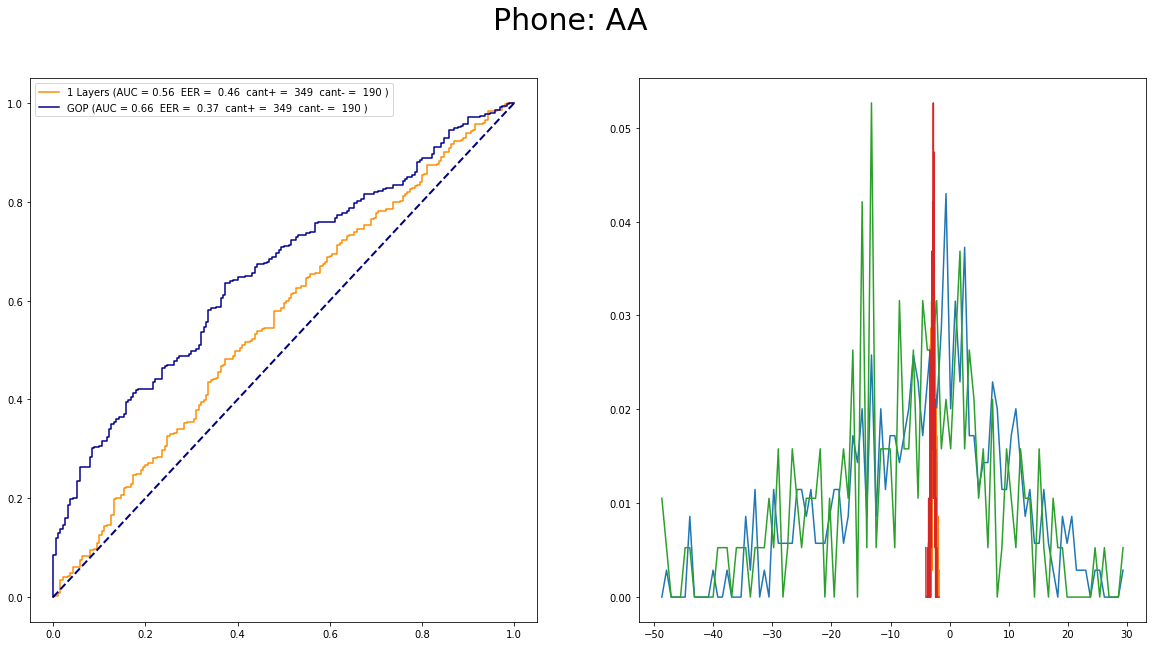

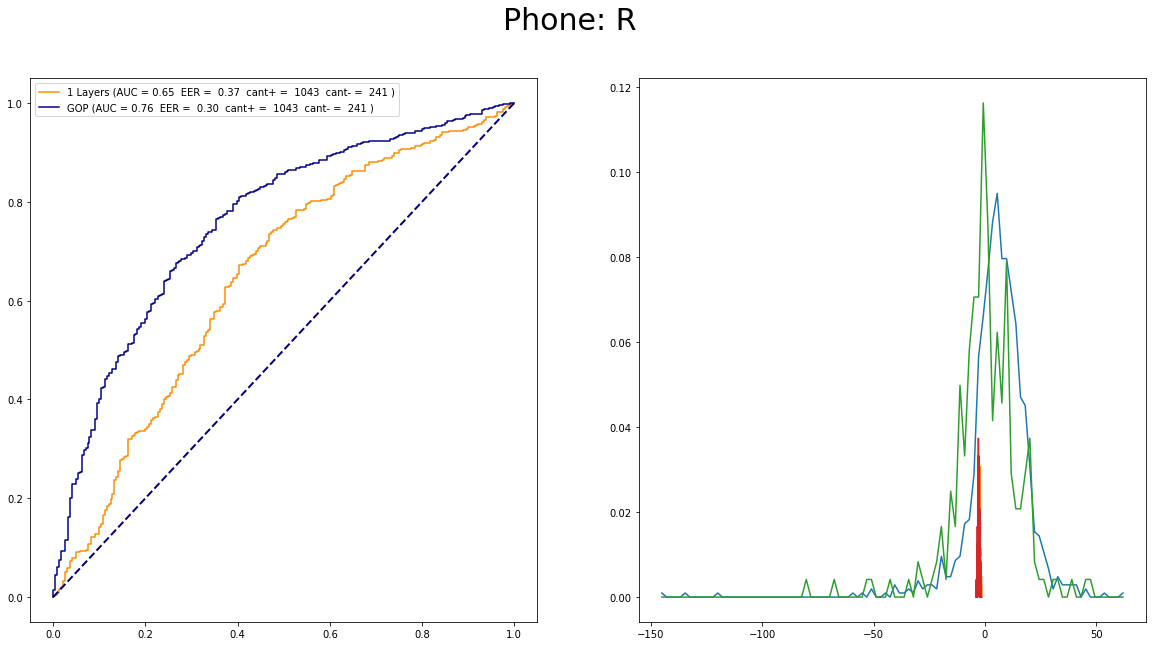

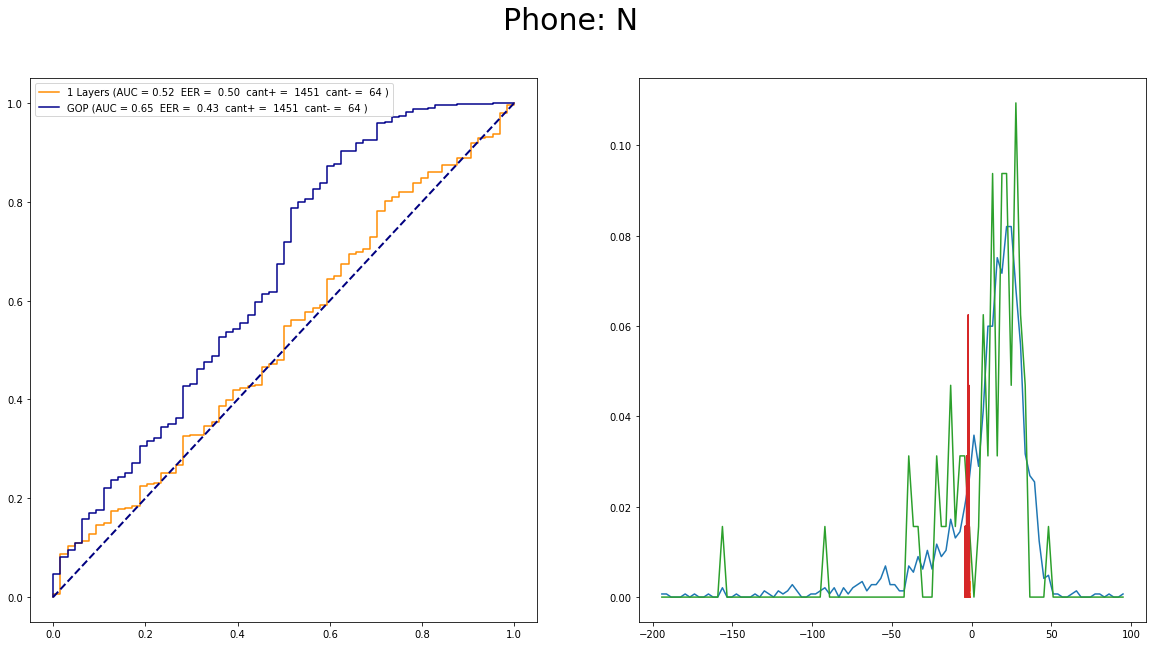

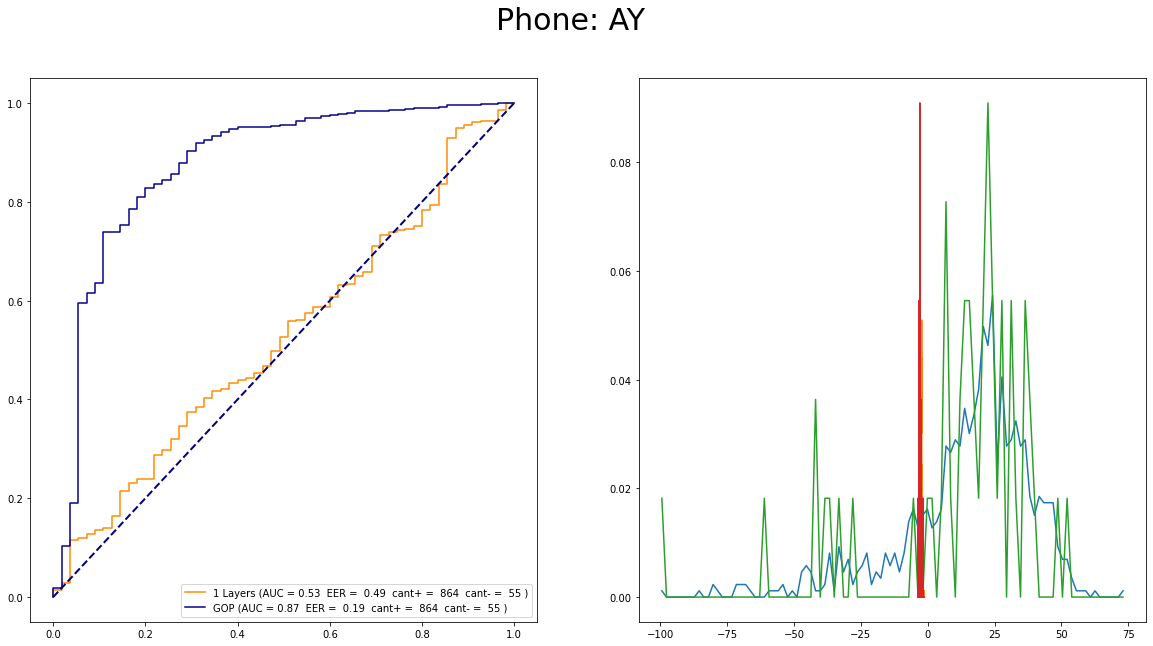

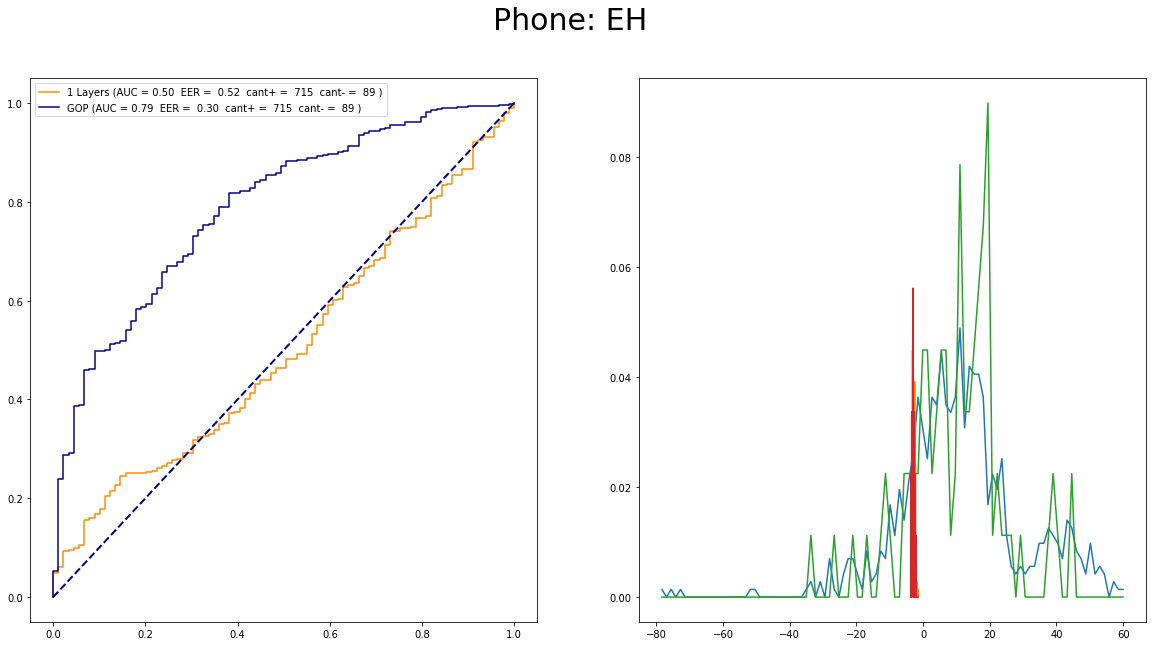

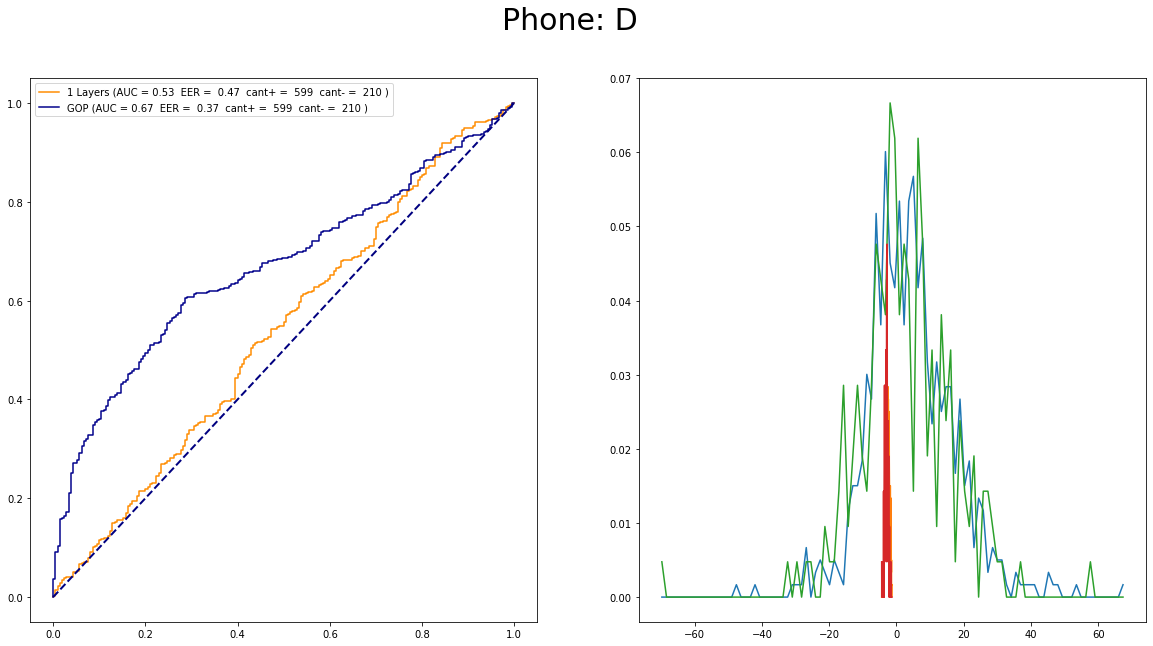

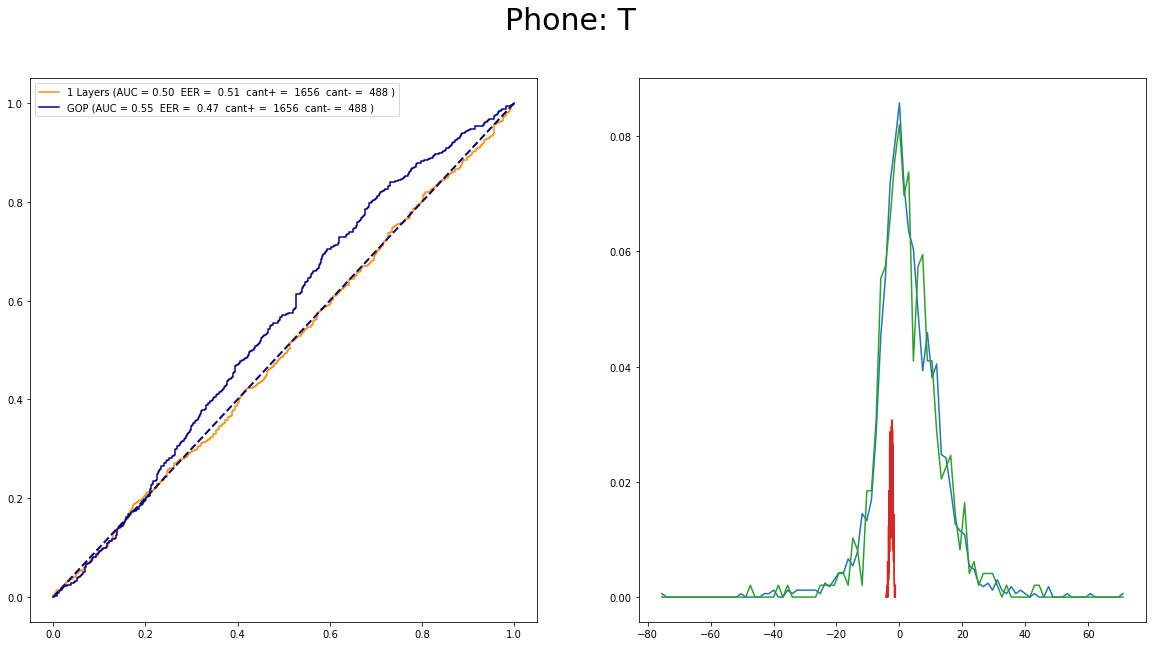

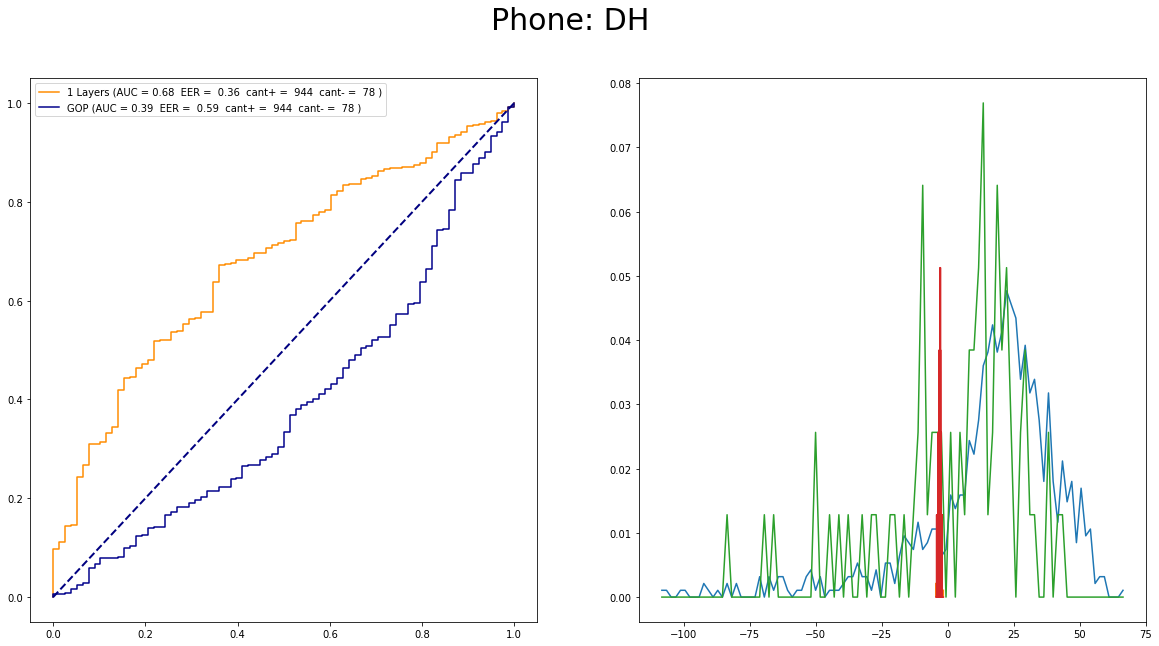

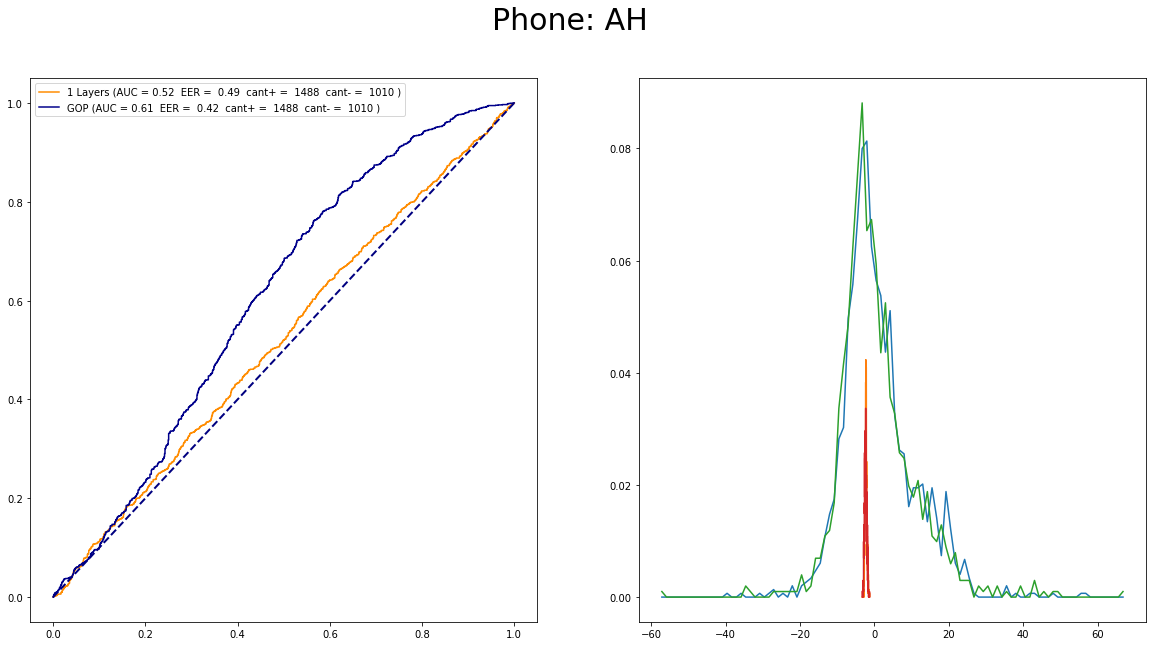

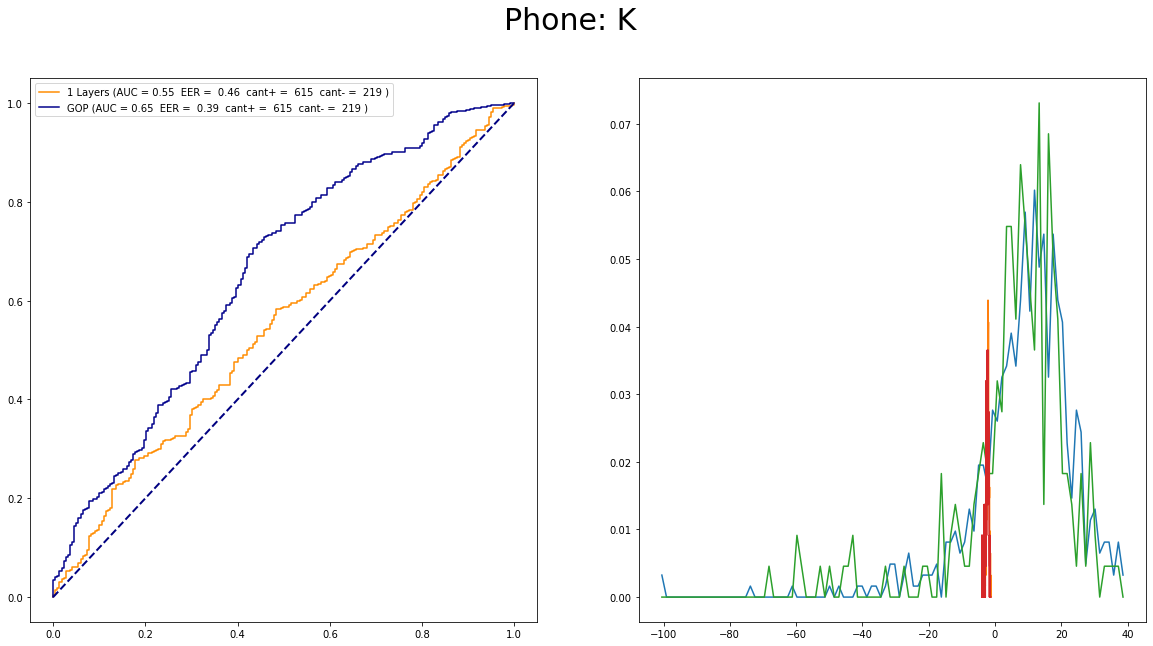

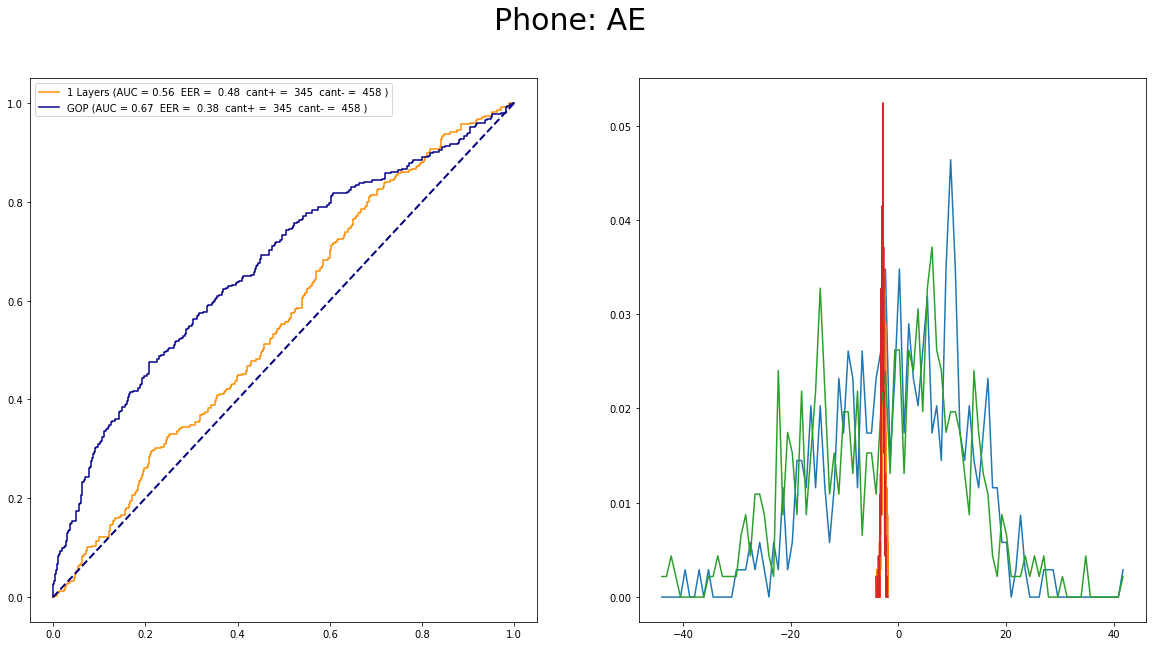

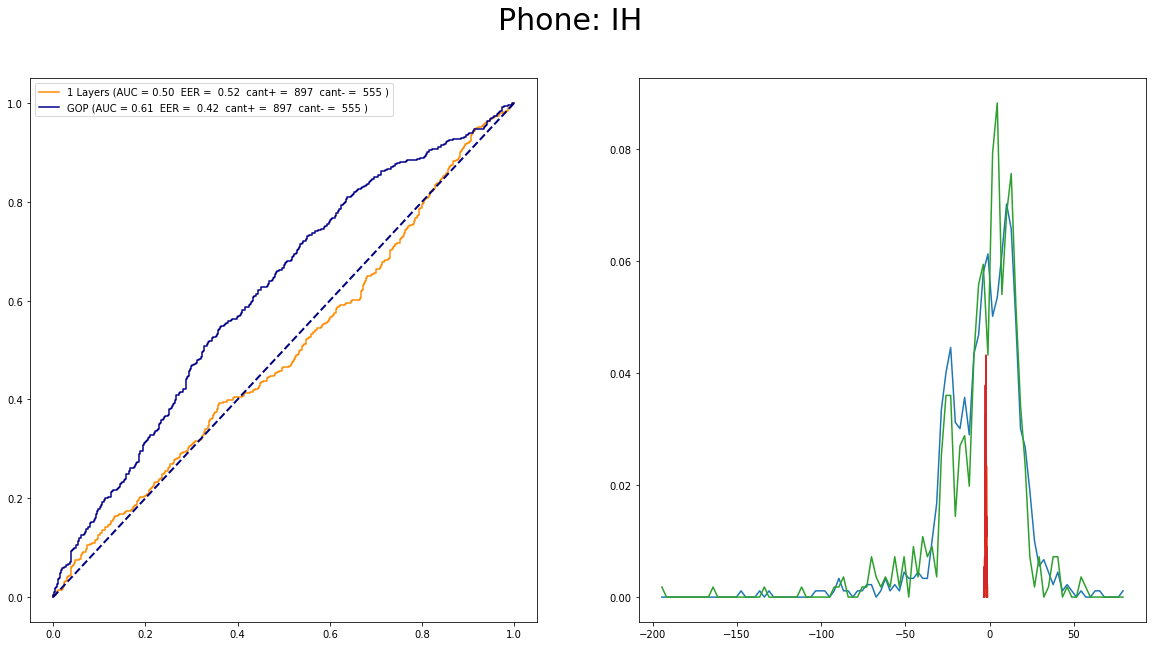

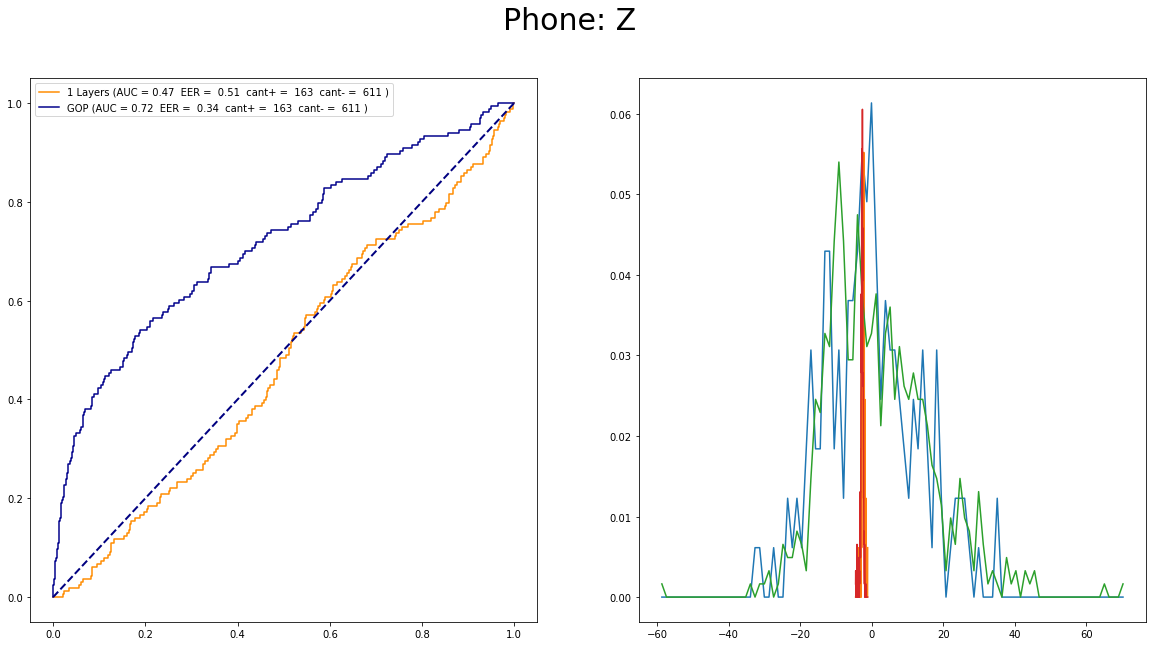

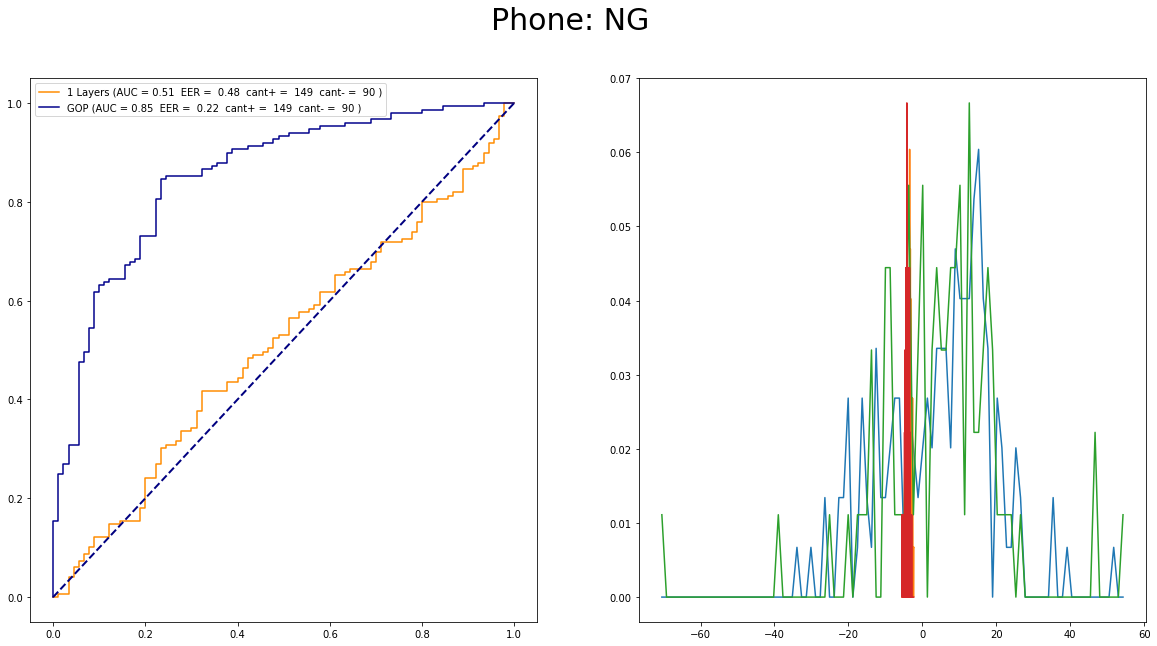

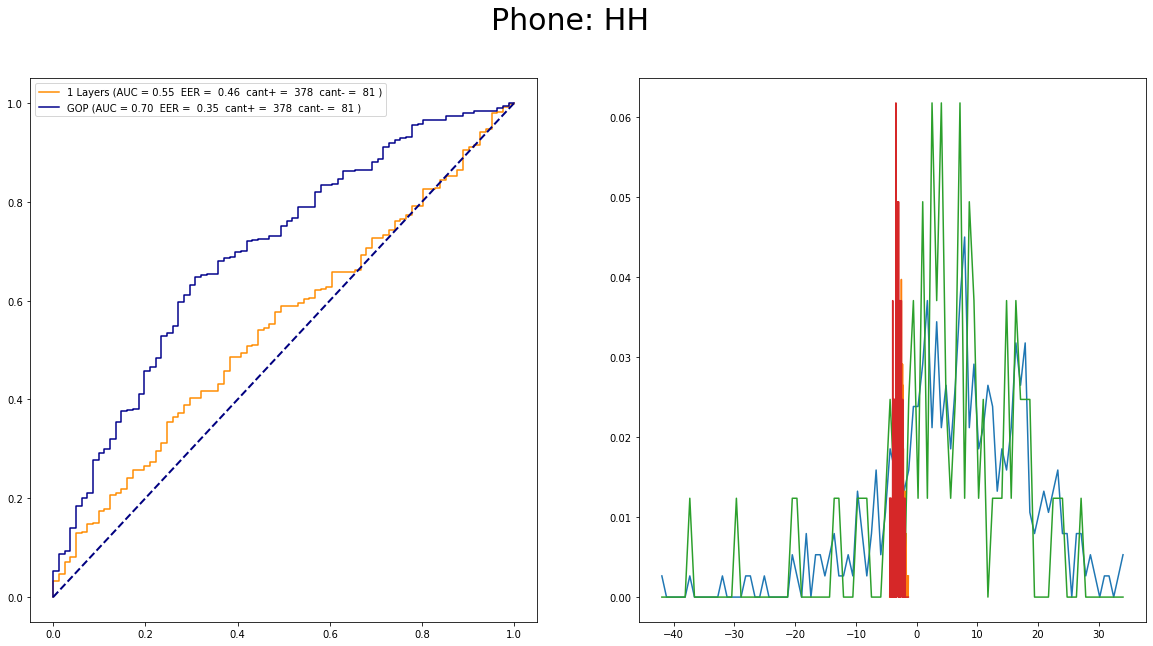

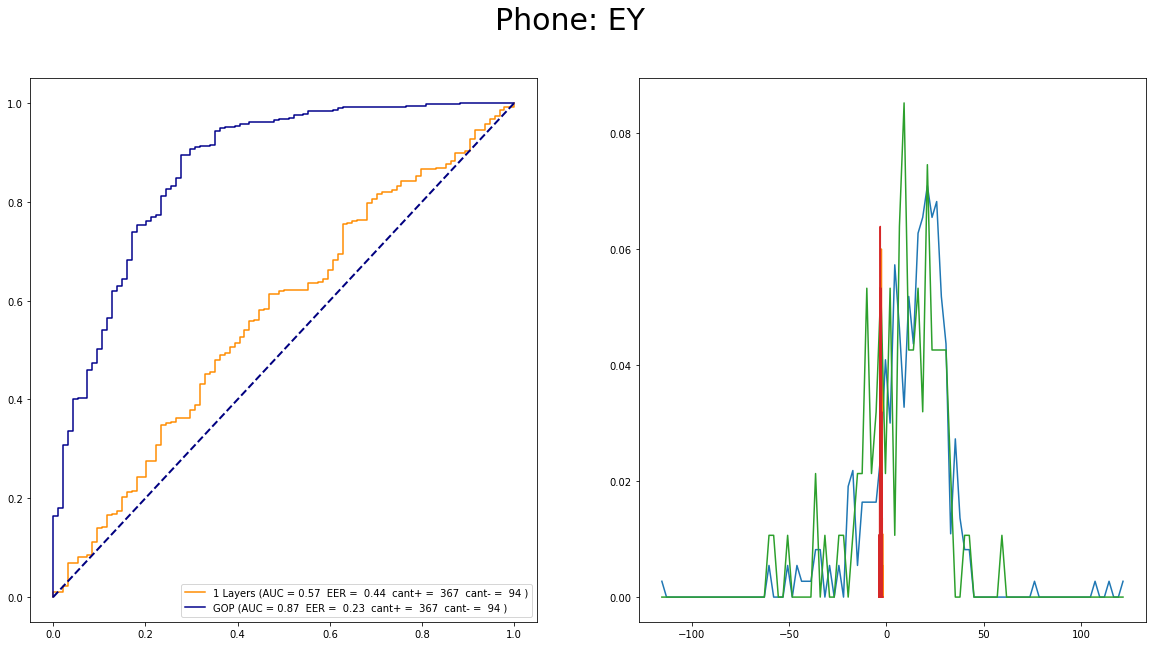

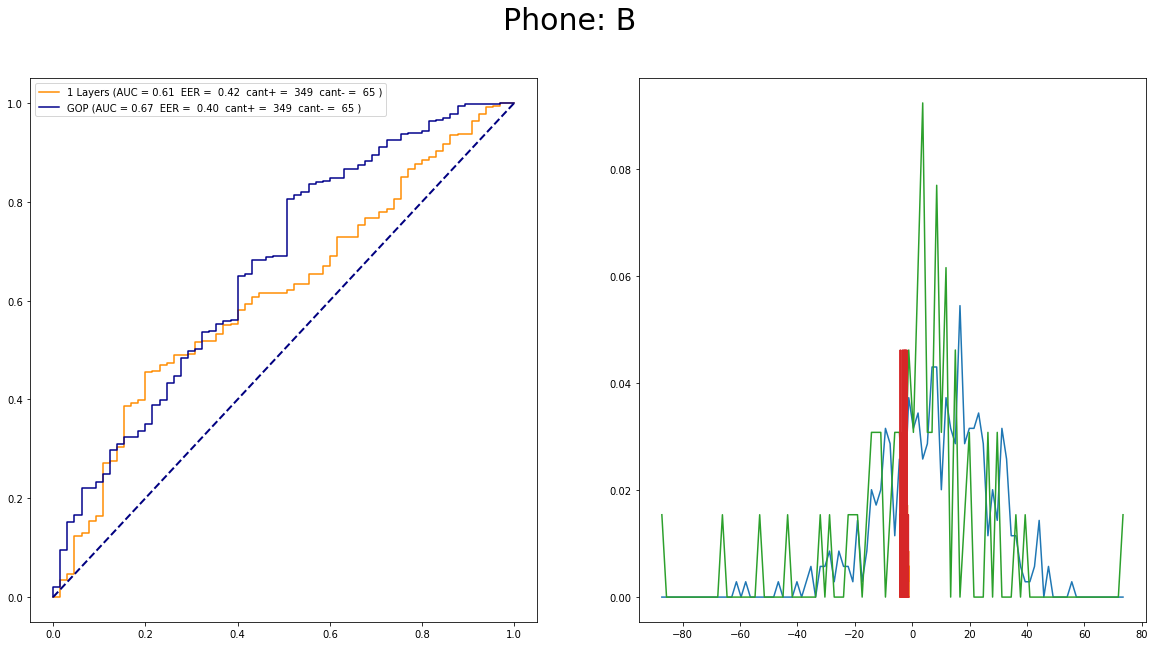

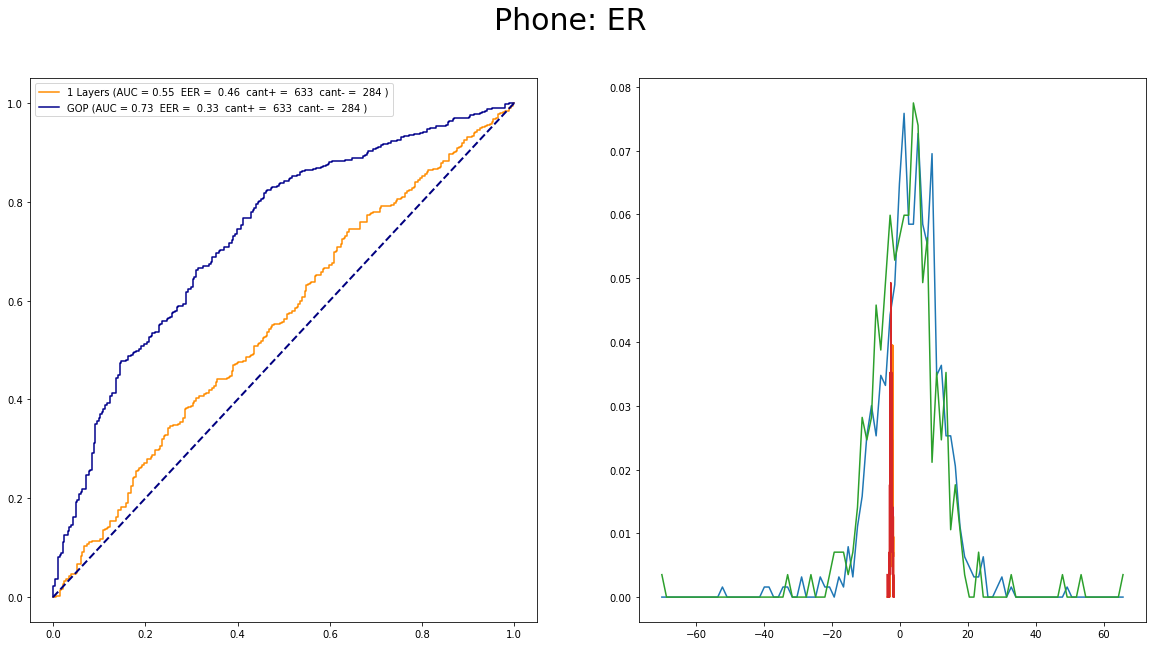

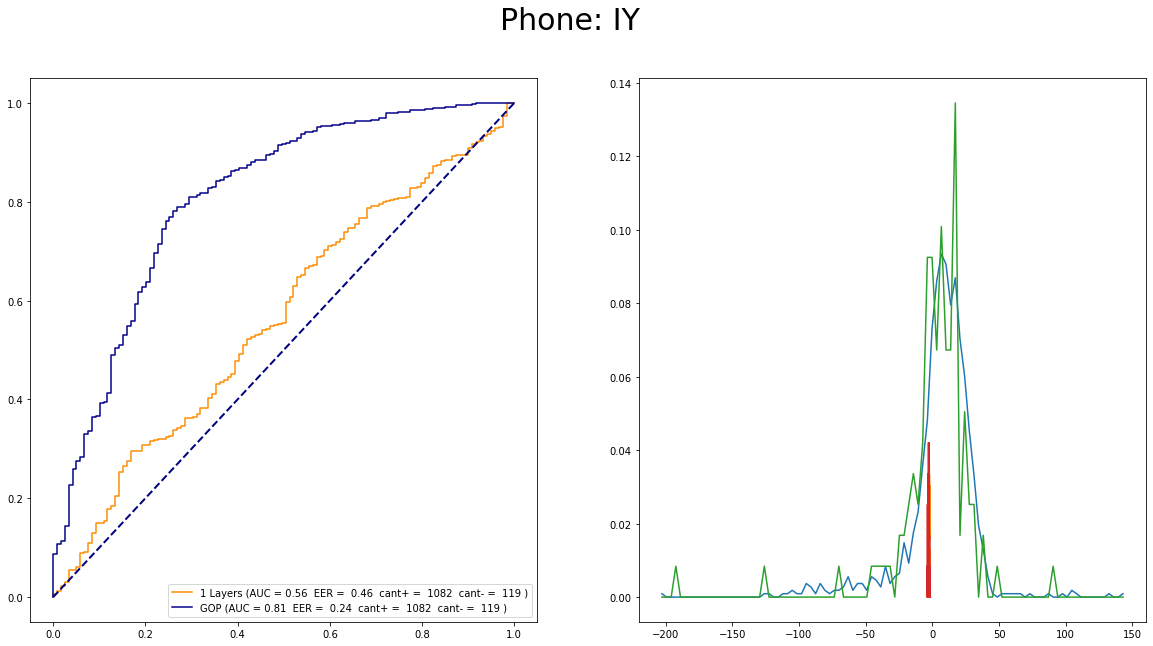

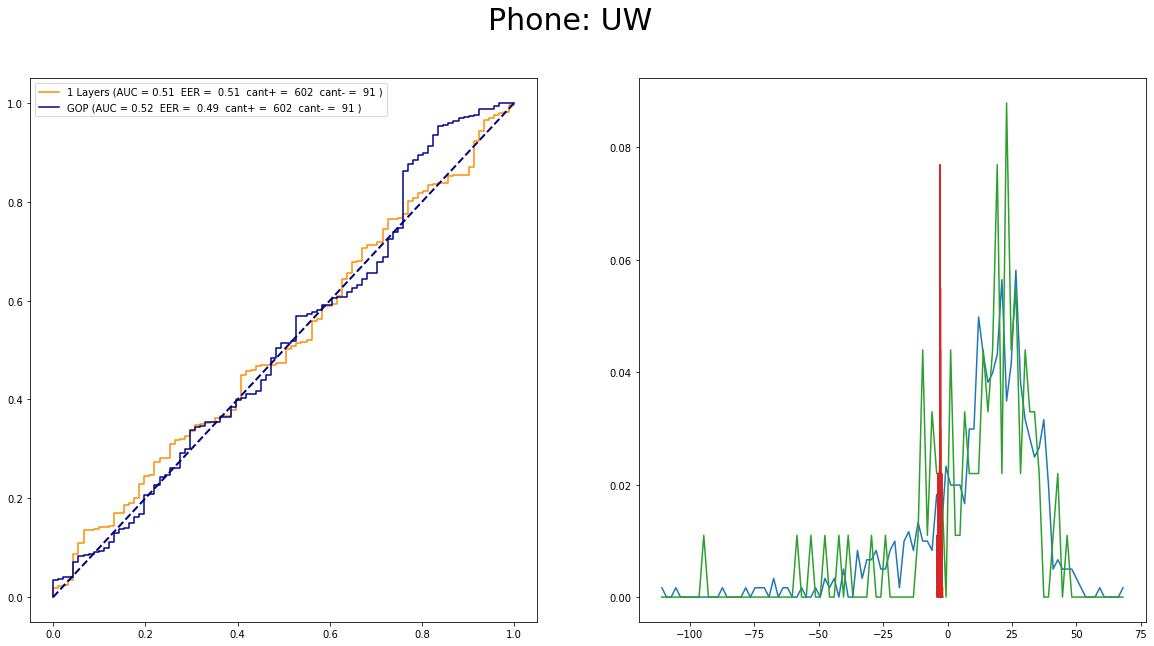

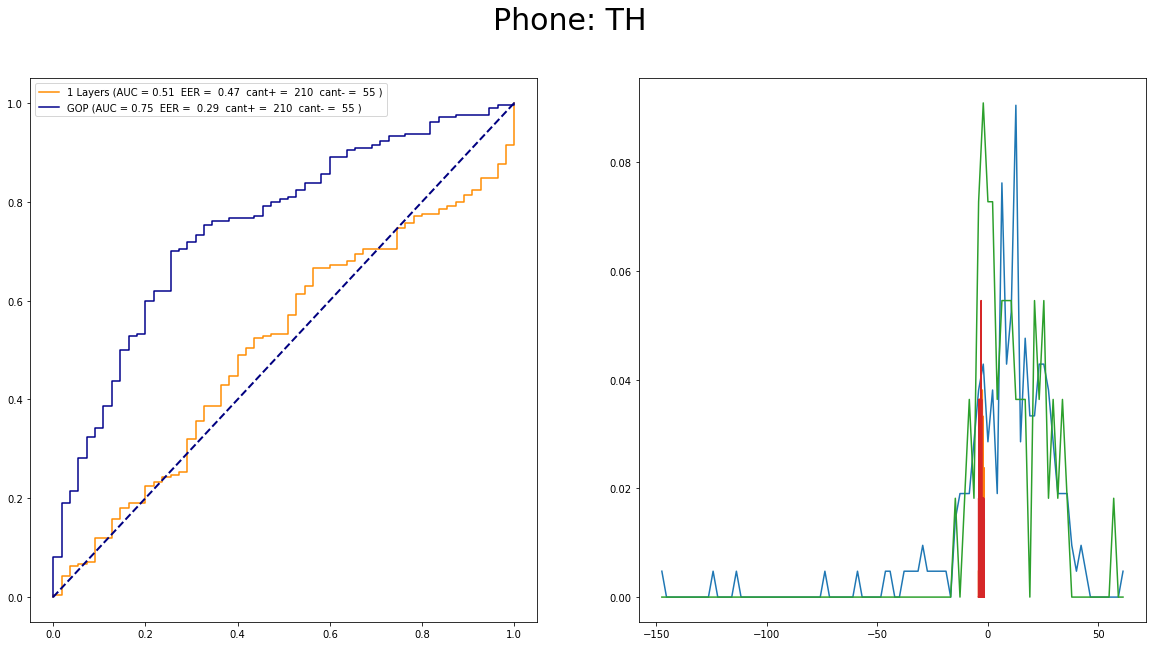

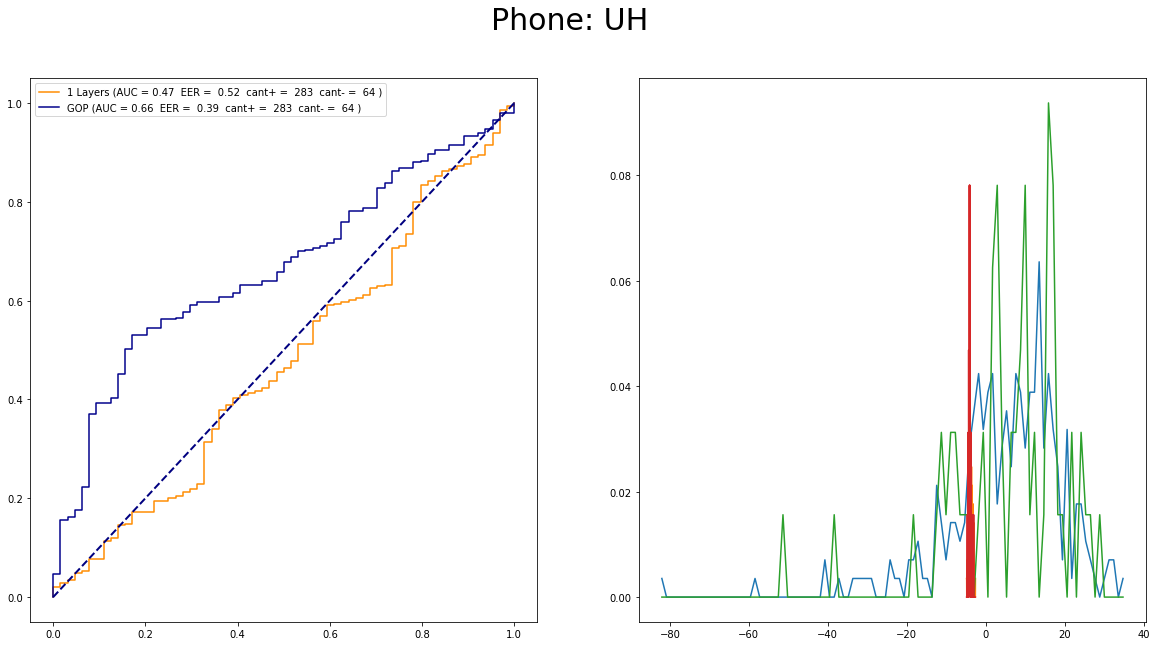

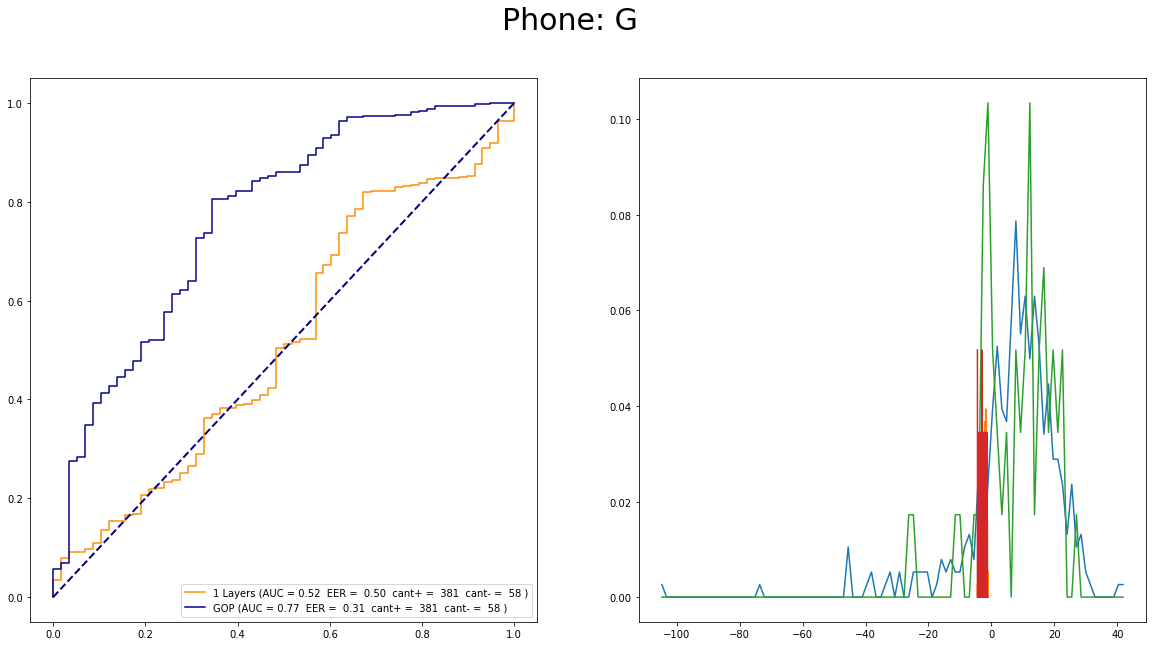

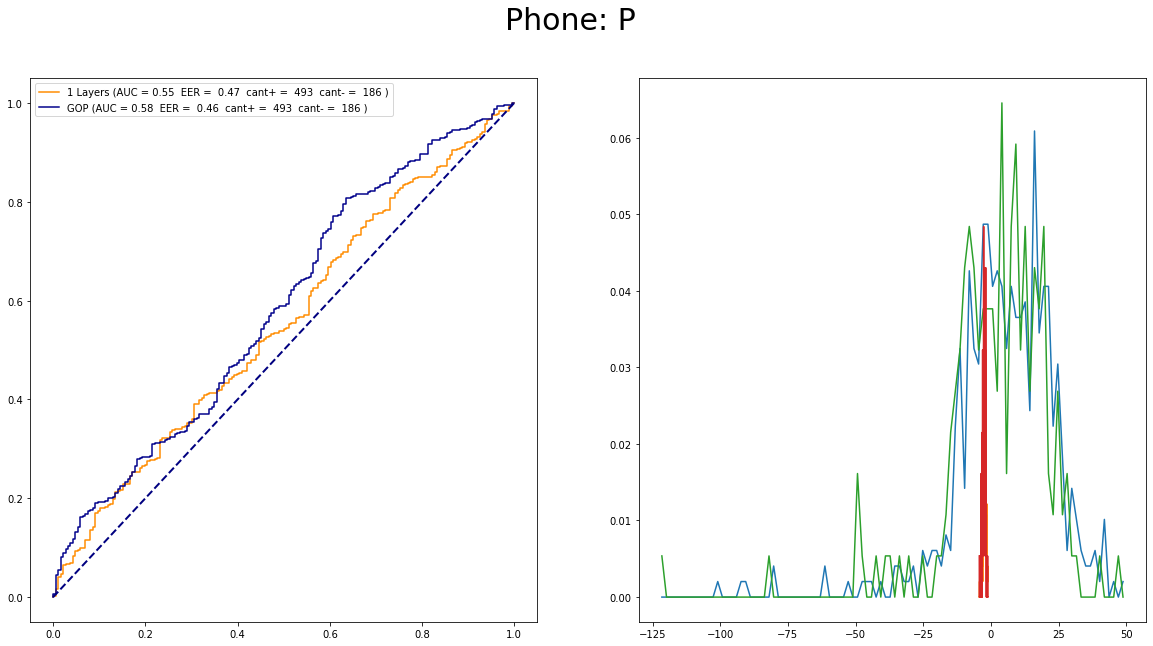

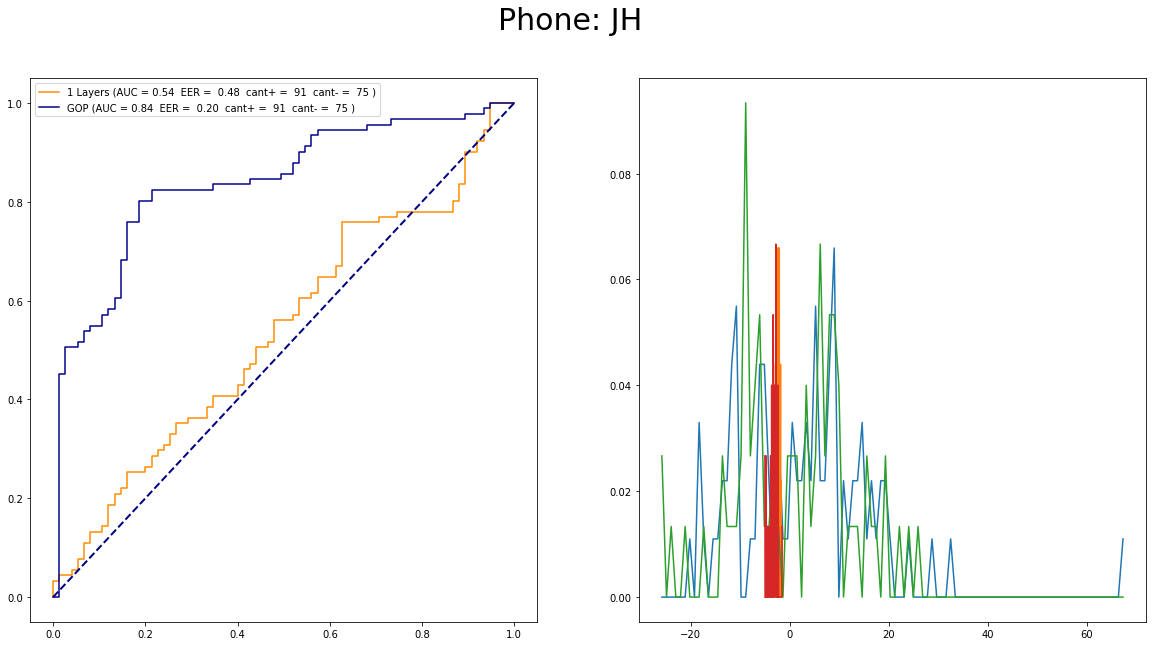

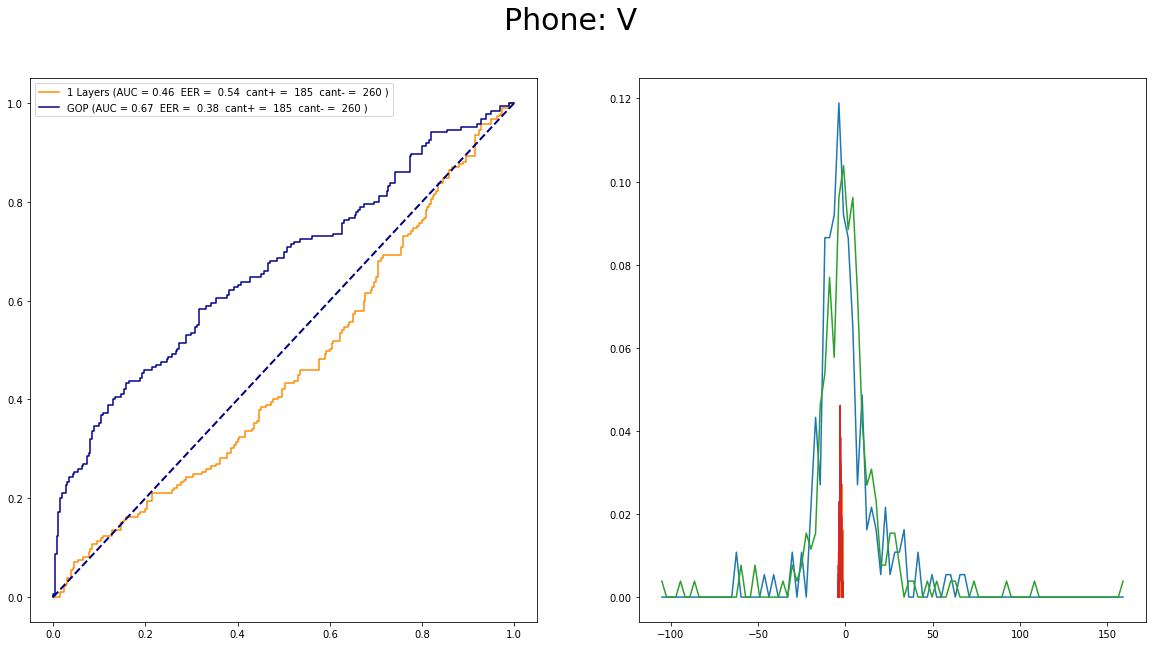

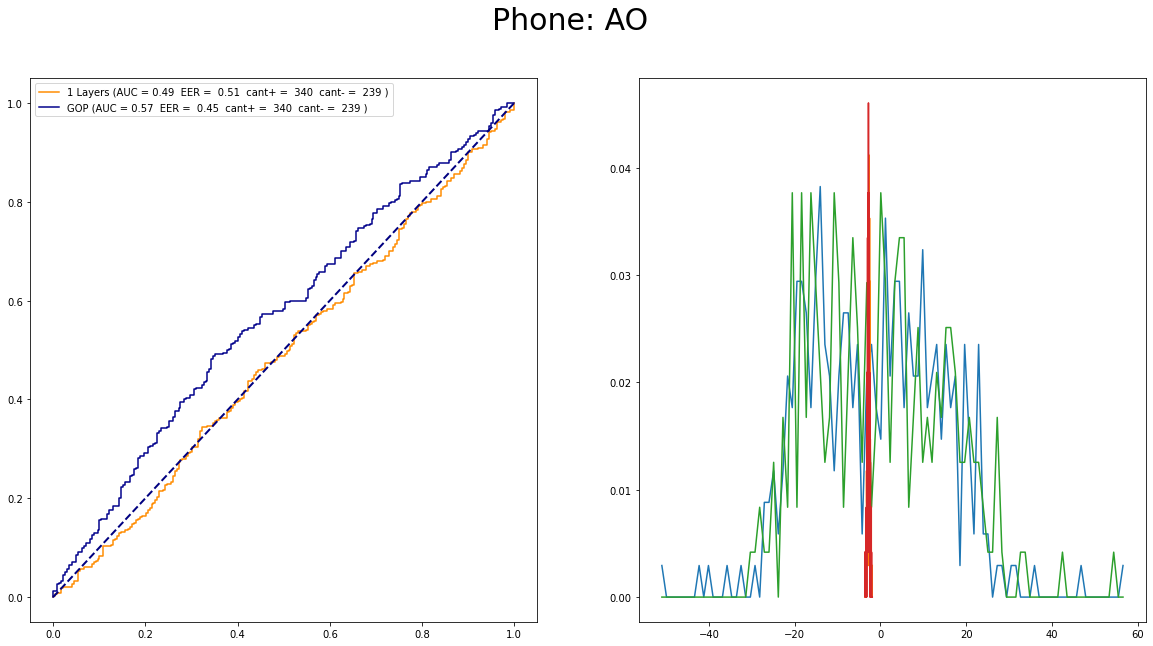

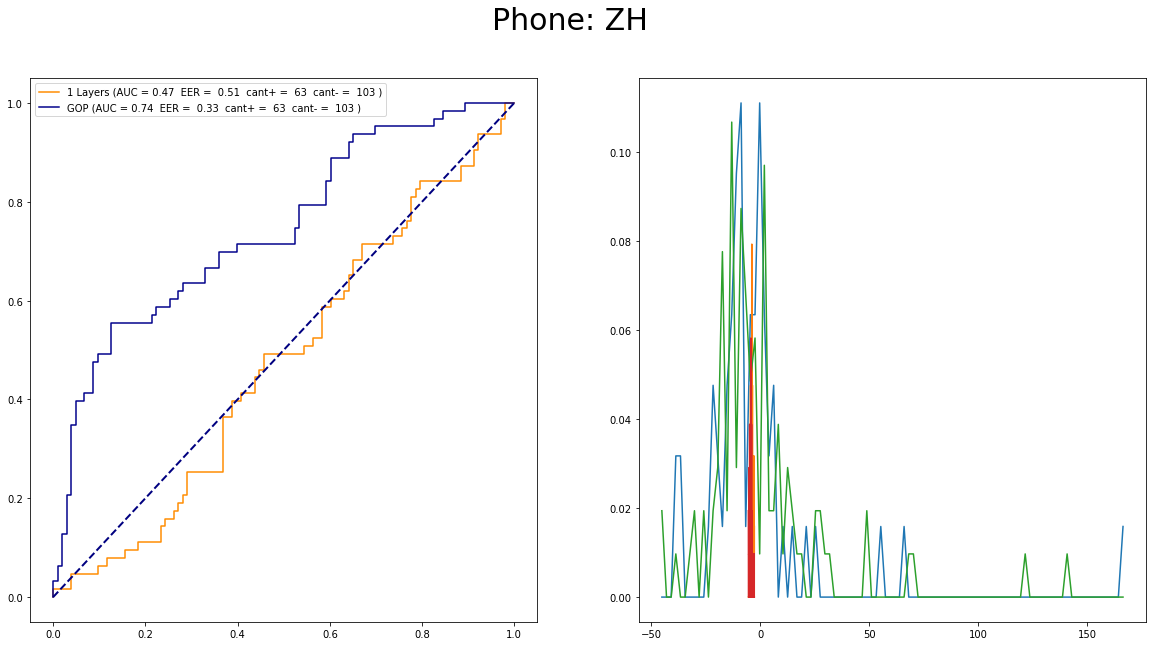

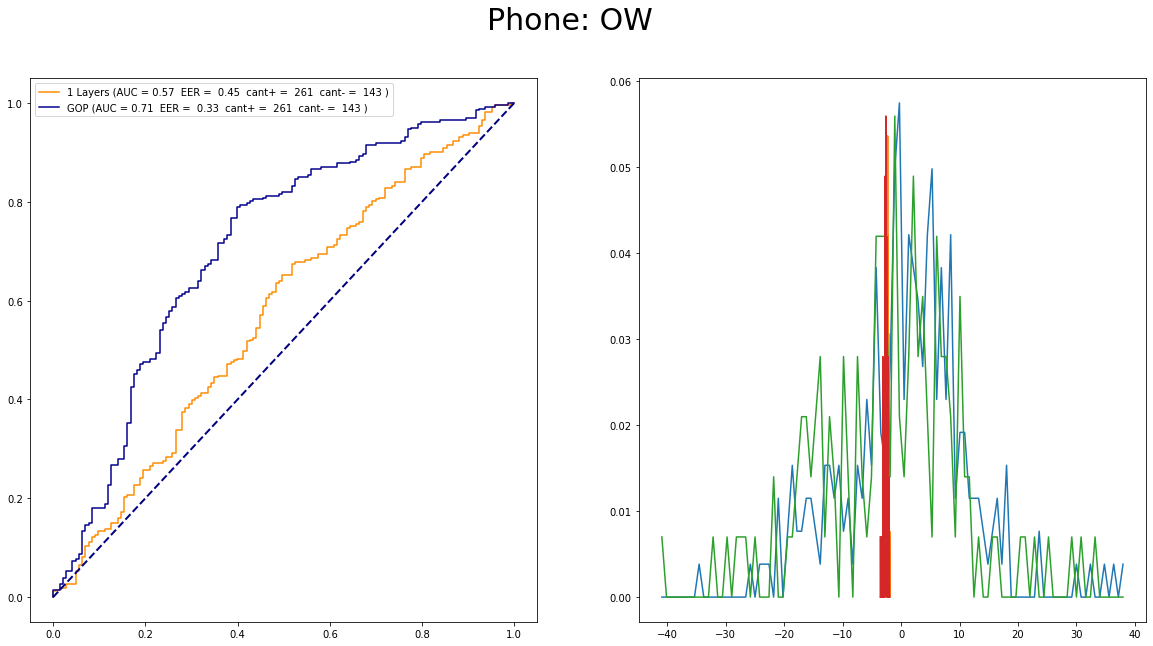

In [18]:
compare_models([df_1layer, df_gop], ["1 Layers", "GOP"], ["darkorange", "darkblue"])